In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import numpy as np
from datetime import datetime

In [2]:
train_dataset = torchvision.datasets.FashionMNIST(
    root=".",
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [3]:
train_dataset.data.max

<function Tensor.max>

In [4]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [5]:
train_dataset.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [6]:
test_dataset = torchvision.datasets.FashionMNIST(
    root="./",
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

In [7]:
# Number of classes
K = len(set(train_dataset.targets.numpy()))
print(f"number of classes: {K}")

number of classes: 10


In [8]:
# Define the model
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.conv_layers =nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
            nn.ReLU()
        )

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(128 * 2 * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, K)
        )

    def forward(self, X):
        out = self.conv_layers(X)
        out = out.view(out.size(0), -1)
        out = self.dense_layers(out)
        return out

In [9]:
# Instantiate the model
model = CNN(K)

In [10]:
# The same model, using Flatten
# model = nn.Sequential(
#     nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
#     nn.ReLU(),
#     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
#     nn.ReLU(),
#     nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
#     nn.ReLU(),
#     nn.Flatten(),
#     nn.Dropout(0.2),
#     nn.Linear(128 * 2 * 2, 512),
#     nn.ReLU(),
#     nn.Dropout(0.2),
#     nn.Linear(512, K)
# )

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [12]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [13]:
# Data loader
# Useful b/c it automatically generates batches in the training loop
# and shuffles the data

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [14]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # Move data to GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        # Get train loss and test loss
        train_loss = np.mean(train_loss)

        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.now() - t0
        print(f"Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
            Test Loss: {test_loss:.4f}, Duration: {dt}")

    return train_losses, test_losses



In [15]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_loader, test_loader, epochs=15)

Epoch 1/15, Train Loss: 0.6752,             Test Loss: 0.5260, Duration: 0:00:07.963634
Epoch 2/15, Train Loss: 0.4469,             Test Loss: 0.4453, Duration: 0:00:07.623285
Epoch 3/15, Train Loss: 0.3894,             Test Loss: 0.3948, Duration: 0:00:07.651050
Epoch 4/15, Train Loss: 0.3512,             Test Loss: 0.3741, Duration: 0:00:07.360568
Epoch 5/15, Train Loss: 0.3236,             Test Loss: 0.3586, Duration: 0:00:07.370216
Epoch 6/15, Train Loss: 0.3035,             Test Loss: 0.3424, Duration: 0:00:07.356593
Epoch 7/15, Train Loss: 0.2839,             Test Loss: 0.3258, Duration: 0:00:08.296523
Epoch 8/15, Train Loss: 0.2665,             Test Loss: 0.3236, Duration: 0:00:07.317735
Epoch 9/15, Train Loss: 0.2537,             Test Loss: 0.3195, Duration: 0:00:07.319644
Epoch 10/15, Train Loss: 0.2366,             Test Loss: 0.3268, Duration: 0:00:07.334454
Epoch 11/15, Train Loss: 0.2250,             Test Loss: 0.3201, Duration: 0:00:07.338876
Epoch 12/15, Train Loss: 0.214

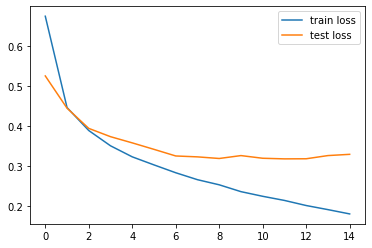

In [16]:
# Plot the train and test loss per iteration
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()
# Seems like the model began overfitting

In [17]:
# Accuracy
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
    # Move the data to GPU
    inputs, targets = inputs.to(device), targets.to(device)

    # Forward pass
    outputs = model(inputs)

    # Get predictions
    # torch.max returns both max and argsmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

train_acc = n_correct / n_total

n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
    # Move the data to GPU
    inputs, targets = inputs.to(device), targets.to(device)

    # Forward pass
    outputs = model(inputs)

    # Get predictions
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total

print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9387, Test acc: 0.8910


Confusion matrix, without normalization
[[880   1  22  13   4   2  72   0   6   0]
 [  2 976   3  11   2   1   4   0   1   0]
 [ 23   2 871   8  50   1  42   0   3   0]
 [ 18   4  16 896  29   1  33   0   3   0]
 [  1   2  72  27 834   0  63   1   0   0]
 [  0   0   0   3   0 962   0  27   1   7]
 [163   2  82  20 106   1 620   0   6   0]
 [  0   0   0   0   0  14   0 967   0  19]
 [  6   0   8   2   8   6   3   5 962   0]
 [  1   0   0   0   0   7   0  38   1 953]]


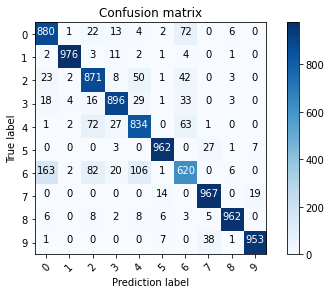

In [20]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, 
                          normalize=False,
                          title="Confusion matrix",
                          cmap=plt.cm.Blues):
    """
    Plots the confusion matrix. Normalization can be set to True
    Args:
        cm (_type_): _description_
        classes (_type_): _description_
        normalize (bool, optional): _description_. Defaults to False.
        title (str, optional): _description_. Defaults to "Confusion matrix".
        cmap (_type_, optional): _description_. Defaults to plt.cm.Blues.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
    
    print(cm)

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Prediction label")
    plt.show()

# Get all predictions in an array and plot confusion matrix

x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])
for inputs, targets in test_loader:
    # Move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    _, predictions = torch.max(outputs, 1)

    # Update p_test
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [21]:
# Label mapping
labels = """
T-shrit/top
Trouser
Pullover
Dress
Coat
Sandla
Shirt
Sneaker
Bag
Ankle Boot
""".split("\n")

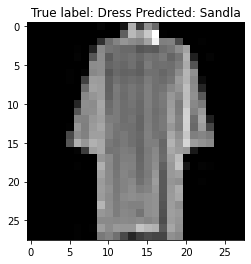

In [23]:
# Show some misclassified examples
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(28,28), cmap='gray')
plt.title(f"True label: {labels[y_test[i]]} Predicted: {labels[p_test[i]]}");